In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,BatchNormalization,Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
train_path = 'D:/Data/HAM100000 - Harvard Dataset/preprocessed_data_15split/train'
test_path = 'D:/Data/HAM100000 - Harvard Dataset/preprocessed_data_15split/val'
batch_size = 16 

In [3]:
# Creating Image Data Generator to augment images
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

batch_size = 50

In [4]:
datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)

In [5]:
image_size = 224
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches =datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)


Train Batches: 
Found 53573 images belonging to 7 classes.

Test Batches: 
Found 1494 images belonging to 7 classes.


In [6]:
#Soft Attention

from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf



class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x

        
        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC
    
        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]
        
        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape
        

        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))

        
        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1) 
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)

        
        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)       
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))
   
            x_exp = K.expand_dims(x,axis=-2)
   
            u = kl.Multiply()([exp_softmax_alpha, x_exp])   
  
            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])   

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u
        
        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape): 
        return [self.out_features_shape, self.out_attention_maps_shape]

    
    def get_config(self):
        return super(SoftAttention,self).get_config()
 

In [7]:
MobileNetV2 = tf.keras.applications.MobileNetV2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,

)
# Exclude the last 28 layers of the model.
conv = MobileNetV2.layers[-28].output

Soft Attention

In [8]:
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)

In [9]:
output = Flatten()(conv)
output = Dense(7, activation='softmax')(output)
model = Model(inputs=MobileNetV2.input, outputs=output)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 soft_attention (SoftAttention)  [(None, 7, 7, 960),  138256     ['block_14_depthwise[0][0]']     
                                 (None, 16, 7, 7)]                                                
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 4, 4, 960)   0           ['block_14_depthwise[0][0]']     
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 4, 4, 960)    0           ['soft_attention[0][0]']         
                                                                                                  
 concatena

In [11]:
opt1=tf.keras.optimizers.Adam(learning_rate=0.01,epsilon=0.1)
model.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [12]:
class_weights = {   
                    0: 1.0,  # akiec
                    1: 1.0,  # bcc
                    2: 1.0,  # bkl
                    3: 1.0,  # df
                    4: 5.0,  # mel
                    5: 1.0,  # nv
                    6: 1.0,  # vasc
                }


checkpoint=  ModelCheckpoint(filepath = 'saved_model.hdf5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=True)

In [13]:
Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=35, min_delta=0.001)
with tf.device('/GPU:0'):
    history = model.fit(train_batches,
#                         steps_per_epoch=9187/10,
                        epochs=150,
#                         verbose=2,
                        validation_data=test_batches,
#                         validation_steps=828/batch_size,
                        callbacks=[checkpoint,Earlystop],class_weight=class_weights)

Epoch 1/150
1072/1072 [==============================] - 1508s 1s/step - loss: 3.7288 - accuracy: 0.3715 - val_loss: 51.1371 - val_accuracy: 0.0515
Epoch 2/150
1072/1072 [==============================] - 294s 274ms/step - loss: 1.6360 - accuracy: 0.5033 - val_loss: 14.4280 - val_accuracy: 0.1285
Epoch 3/150
1072/1072 [==============================] - 285s 266ms/step - loss: 1.4009 - accuracy: 0.5671 - val_loss: 3.9581 - val_accuracy: 0.1767
Epoch 4/150
1072/1072 [==============================] - 289s 270ms/step - loss: 1.1801 - accuracy: 0.6355 - val_loss: 1.2125 - val_accuracy: 0.5335
Epoch 5/150
1072/1072 [==============================] - 268s 250ms/step - loss: 1.0421 - accuracy: 0.6821 - val_loss: 1.0158 - val_accuracy: 0.6720
Epoch 6/150
1072/1072 [==============================] - 371s 346ms/step - loss: 0.9308 - accuracy: 0.7152 - val_loss: 0.7934 - val_accuracy: 0.6894
Epoch 7/150
1072/1072 [==============================] - 379s 353ms/step - loss: 0.8217 - accuracy: 0.7494

In [14]:
from tensorflow.keras import models
model.load_weights("saved_model.hdf5")

In [15]:
predictions = model.predict(test_batches, 
#                             steps=len(test_df)/batch_size, verbose=0
                           )

In [16]:
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob=predictions
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

# Creating classification report 
report = classification_report(y_true, y_pred, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       akiec       0.83      0.39      0.53        49
         bcc       0.67      0.75      0.71        77
         bkl       0.67      0.71      0.69       164
          df       0.54      0.41      0.47        17
         mel       0.61      0.63      0.62       167
          nv       0.91      0.92      0.92       999
        vasc       0.88      0.71      0.79        21

    accuracy                           0.83      1494
   macro avg       0.73      0.65      0.68      1494
weighted avg       0.83      0.83      0.83      1494



In [17]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("weighted Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='weighted')))

Precision: 0.8331675548332448
Recall: 0.8313253012048193
Accuracy: 0.8313253012048193
weighted Roc score: 0.9499821541701072


In [18]:

print("Precision: "+ str(precision_score(y_true, y_pred, average='macro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='macro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("Macro Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='macro')))

Precision: 0.730887571288812
Recall: 0.6480169099207221
Accuracy: 0.8313253012048193
Macro Roc score: 0.9609588918873365


In [19]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='micro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='micro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
tpr={}
fpr={}
roc_auc={}
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro Roc score: " + str(roc_auc["micro"]))

Precision: 0.8313253012048193
Recall: 0.8313253012048193
Accuracy: 0.8313253012048193
Micro Roc score: 0.9792641486666582


In [20]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(7):
    r = roc_auc_score(y_test[:, i], y_prob[:, i])
    print("The ROC AUC score of "+targetnames[i]+" is: "+str(r))

The ROC AUC score of akiec is: 0.9729256408445731
The ROC AUC score of bcc is: 0.968398573903161
The ROC AUC score of bkl is: 0.9364753346781587
The ROC AUC score of df is: 0.9711458042932812
The ROC AUC score of mel is: 0.9282294491649707
The ROC AUC score of nv is: 0.9519297074852631
The ROC AUC score of vasc is: 0.9976077328419488


In [21]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

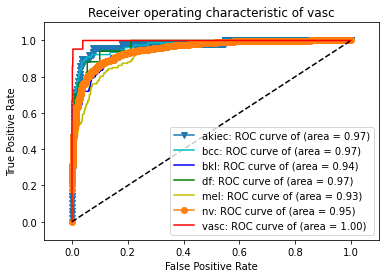

In [22]:

plt.plot(fpr[0], tpr[0],'v-',label='akiec: ROC curve of (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1],'c',label='bcc: ROC curve of (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2],'b',label='bkl: ROC curve of (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3],'g',label='df: ROC curve of (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4],'y',label='mel: ROC curve of (area = %0.2f)' % roc_auc[4])
plt.plot(fpr[5], tpr[5],'o-',label='nv: ROC curve of (area = %0.2f)' % roc_auc[5])
plt.plot(fpr[6], tpr[6],'r',label='vasc: ROC curve of (area = %0.2f)' % roc_auc[6])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of %s'%targetnames[i])
plt.legend(loc="lower right")
plt.show()